**<center><font size=5>E.T. Signal Search 👽</font></center>**

----
# Background

##### **"Are we alone in the Universe?"**

It's one of the most profound human questions.
As technology improves, we're finding new and more powerful ways to seek for answers.

The Breakthrough Listen team at Berkeley University, scans signals from millions of stars in the universe using world's most powerful telescopes.
But it is not that easy - by the time, humans have built enormous numbers of radio device that can be detected as signals as well and distract our signals interpetation.

In order to handle this challange, they are using two different methods:
1. They intersperses scans of target stars that apprears in more than one regions of the sky - because it's probably isn't coming from the direction of target star.
2. They discards signals that don't change their frequency - because it means that they are probably nearby the telescope.

These two methods are quite effective, but they can be improved. The process today misses interesting signals. particularly those with complex time or frequency structure, and those in regions of the spectrum with lots of interference

(from a [kaggle competition](https://www.kaggle.com/competitions/seti-breakthrough-listen)) <br></br>

----

**Table of Contents**
- <a href='#1'>1. Project overview</a>
  - <a href='#1_1'>1.1. Methodology</a>
  - <a href='#1_2'>1.2. Imports, Methods, Paths, Reading definitions</a>
- <a href='#2'>2. EDA: Exploratory Data Analysis</a>
  - <a href='#2_1'>2.1. Load The Data</a>
  - <a href='#2_2'>2.2. Visualize The Data</a>
  - <a href='#2_3'>2.3. Summery Statistics</a>
- <a href='#3'>3. Data Preprocessing</a>
  - <a href='#3_1'>3.1. Data Augmentation</a>
  - <a href='#3_2'>2.2. Feature Extraction</a>
  - <a href='#3_3'>2.3. Data Splitting</a>

  ----

# <a id='1'>1. Project overview</a>

We are about to use supervised learning skills to train and test a model that can help classify the presence of simulated extraterrestial signals in Breakthrough Listen team signal's scans.

Because there are no confirmed examples of alien signals to use to train machine learning algorithms, the team included some simulated signals (that they call “**needles**”) in the haystack of data from the telescope. They have identified some of the hidden needles so that we can train our model to find more.

### <a id='1_1'>1.1. Methodology</a>

1. EDA
2. Instantiate GPU/TPU strategy
3. Data preprocessing
4. Build appropriate model
5. Train and test it
6. Conclusions

### <a id='1_2'>1.2. Imports, Methods, Paths, Reading definitions</a>

1. Import Libraries

In [3]:
%pip install setigen
#%pip install efficientnet
#%pip install numpy
#%pip install pandas
#%pip install opencv-python
#%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
# For operating system and file system
import os

# For data manipulation and analysis
import numpy as np
import pandas as pd

# For Computer Vision Library
import cv2 as cv

# For Machine Learning
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# For SETI data manipulation
#import setigen as stg
from astropy import units as u

# For data visualization
import matplotlib.pyplot as plt

# For basic functionallity
import math
from enum import Enum
from itertools import chain, permutations, combinations

In [5]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

2. Libraries Version

In [6]:
print('np version:',np.__version__)
print('pd version:',pd.__version__)
print('TensorFlow version:',tf.__version__)

np version: 1.26.4
pd version: 2.1.4
TensorFlow version: 2.16.1


3. Configuration

In [8]:
# ------------------------------------#
# Paths
# ------------------------------------#
base_folder_path = "../"
dtaset_folder_path = "../"

4. Methods

In [7]:
def get_batched_data (data, batch_size, index):
  return data[index * batch_size : (index + 1) * batch_size]

----

# <a id='2'>2. EDA: Exploratory Data Analysis </a>


With our libraries and configurations set up, we begin the exploratory data analysis or EDA.

The **goal of EDA** is to understand the data underlying structure and patterns, identify important variables, detect outliers and anomalies and formulate hypotheses for further investigation. <br></br>

This process will involve several steps including:
1. Load the data
2. Visualize the data
3. Summery statistics


### <a id='2_1'>2.1. Load The Data</a>

Even though our task sounds like a *signal* detection problem, it is actually an
*image* classification problem.

The data we are provided with is radio spectrograms - a visual representation of the spectrum frequencies of a signal as it varies with time. <br></br>


Our dataset actually contains:
- a `train_labels.csv` file, which has our labels indicating the presence of an alien signal (referred to as needles) for each of the spectograms
- `train` folder contains `.npy` files with the spectrograms stored as arrays
- Similarly, `test` folder also contains `.npy` files with the test spectrograms stored as arrays
- Of course, we are provided with a `test_labels.csv` file! <br></br>

Let's check our `train` data:

In [10]:
train = pd.read_csv('data/train_labels.csv')

def get_train_file_path(image_id):
  return 'data/train/{}/{}.npy'.format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)

display(train.head())

,id,target,file_path
0,0000799a2b2c42d,0,data/train/0/0000799a2b2c42d.npy
1,00042890562ff68,0,data/train/0/00042890562ff68.npy
2,0005364cdcb8e5b,0,data/train/0/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,data/train/0/0007a5a46901c56.npy
4,0009283e145448e,0,data/train/0/0009283e145448e.npy


### <a id='2_2'>2.2. Visualize The Data</a>

All the spectrograms are saved as numpy arrays. Typically, the data comes with extra metadata, but the organizes said that:

> For the purposes of the Kaggle challenge, we have discarded the majority of the metadata and are simply presenting numpy arrays consisting of small regions of the spectrograms that we refer to as “snippets”

In [ ]:
spectrogram_example = np.load('example.npy')

print(f"Spectrogram shape is: {spectrogram_example.shape}")

As we can see, the spectrogram has a shape of `(6, 273, 256)`. But, in order to undestand what does it mean, we need to dive deeper to how spectrogram works: <br></br>

The main obstacle of searching for candidate signatures of extraterrestrial technology is our human technology - radio stations, wifi routers, cellphones and more also gives off radio signals.


In order to isolate the relevant signals from human-generated ones, Breakthrough Listen team will look for **signals that appear to be coming from particular positions on the sky**. <br></br>


Typically they do this by alternating observations of a primary target star with observations of three nearby stars:
- 5 minutes on star “A”
- then 5 minutes on star “B”
- then back to star “A” for 5 minutes
- then “C”
- then back to “A”
- then finishing with 5 minutes on star “D”.

One set of six observations (ABACAD) is referred to as a *cadence*. <br></br>

Let's look on a visual example for *cadence snippet*, from the interplanetary  [Voyager 1](https://en.wikipedia.org/wiki/Voyager_1) spacecraft:

<img src="https://storage.googleapis.com/kaggle-media/competitions/SETI-Berkeley/Screen%20Shot%202021-05-03%20at%2011.39.42.png" width="600">
<br></br>

 The first, third, and fifth panels are the “A” target (the spacecraft, in this case). The yellow diagonal line is the radio signal coming from Voyager - it’s a diagonal line because the relative motion of the Earth and Doppler effect causing the frequency to change over time.



More information about the spectrograms are provided [here](https://www.kaggle.com/c/seti-breakthrough-listen/overview/data-information). <br></br>

Now we can plot a positive and negative *cadence snippets*:

In [ ]:
def plot_spectrograms(cadence):
    figure = plt.figure(figsize=(8, 5))
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        plt.imshow(cadence[i].astype(float), aspect='auto')
    figure.text(0.5, 0.04, 'Frequency', ha='center', fontsize=8)
    figure.text(0.04, 0.5, 'Time', va='center', rotation='vertical', fontsize=8)
    plt.show()

negative_example = spectrogram_example
positive_example = np.load('positive.npy')

print("Here is a negative example:\n")
plot_spectrograms(negative_example)
print("\nHere is a positive one:\n")
plot_spectrograms(positive_example)

2.3 Summery Statistics
Add blockquote

Let's create a histogram of the label frequencies in order to understand how rare is having a "needle" occurance:

In [ ]:
train.hist()

needles = len(train[train.target==1])

print(f"There are {needles} 'needles', which is {(needles / len(train) * 100)} % of the training set. \n")

Looks like our dataset is very imbalanced - This must be accounted for during modeling (for example, the loss function must be adjusted to account for the imbalance).

----

# <a id='3'>3. Data Preprocessing</a>

There are a few things we can do to make the data more effiecient for our needs:

1. **Data Cleaning** - we can remove noises from the data and keep only the relevant features of the data.
2. **Data Augmentation** - we can apply data augmentation techniques to increase the diversity of the training dataset, like - rotation, flipping, scaling, or adding noise to the spectrograms.
3. **Feature Extraction** - we can extract features that can help distinguishing between human-generated signals and potential alien signals, like - signal intensity, frequency characteristics and more
4. **Data Splitting** - we need to split our train dataset into `training` and `validation` datasets in order to evaluate the performance of our model effectively and improve it. (cross validation - k fold)


### <a id='3_1'>3.1. Data Cleaning </a>


##### <a id='3_1_1'>3.1.1 FT </a>
As we can see in the data visualizations - the horizontal lines are mostly noise and can be eliminated (the vertical or inclined lines are the ones that relevant for us)

For filtering out horizontal lines, we can use `Fourier Transform`, but first - we need to understand its meaning


>In the picture below, we can see the **Time Domain** representation of a audio signal, which shows the "loudness" (amplitude) of sounds wave changing with time. To better understand a audio signal, it is necessary to transform it into the **Frequency Domain** representation. This representation of a signal tells us what different frequencies are present in the signal.<br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*e-_z80BnbHWyFTfRLblJ_w.gif" width="400"> <br></br>
> **Fourier Transform** is a mathematical concept that can *decompose a signal into its constituent frequencies*. In its 2D plot output, the x-axis represent the signal frequencies and the y-axis represent their magnitudes (amplitude size). There is also **Inverse Fourier Transform** concept, which is just the opposite of the Fourier Transform.<br></br>
 For a better understanding of Fourier Transform output - let's create two simple sine waves, with two different frequencies:  *amplitude = 1 and frequency = 3* and *amplitude = 2 and frequency = 11*.
 Now, we can combine them into a single signal, that will look like that - <br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*WBldOpArJgDXIFs5g_JydA.png" width="400"> <br></br>
> The output of Fourier Transform will show two spikes  for the two frequencies and their magnitues <br></br>
  <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*aIyR6XoUYGJp0_3Ug6iEyA.png" width="400"> <br></br>
for more information  [understand autio fft](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520)


<br></br>
Having said that, we can use *Fourier Transform* to mask the spectrogram's horizontal lines - they are represented as vertical lines in the central area of the fourier image:

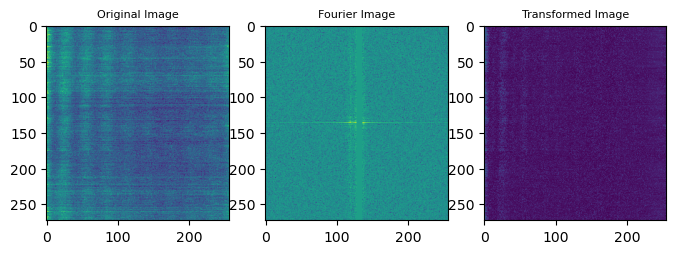

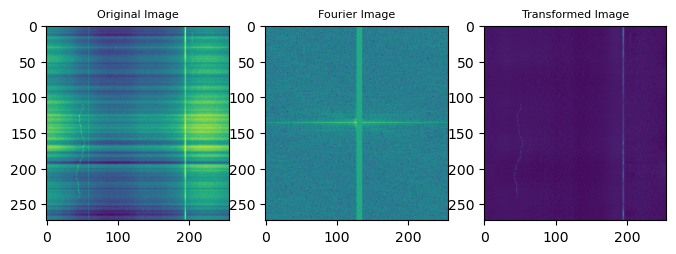

In [21]:
def fourier_vertical_lines_mask(spectrogram):
    spectrogram_frequencies_domain = np.fft.fft2(spectrogram)
    # Shitf the zero-frequency to the center of the image, making it more intuitively
    spectrogram_frequencies_domain = np.fft.fftshift(spectrogram_frequencies_domain)
    # Mask the central area of the fourier image (probably a horizontal line)
    spectrogram_frequencies_domain[:, 128:136] = 1

    return spectrogram_frequencies_domain

def plot_fourier_vertical_lines_mask(spectrogram, frequencies_domain):
    _ , columns = plt.subplots(1,3,figsize=(8,8))

    # Original Image
    columns[0].imshow(spectrogram)
    columns[0].set_title('Original Image', fontsize = 8);
    # Fourier Transformation Image
    columns[1].imshow(np.log(abs(frequencies_domain)))
    columns[1].set_title('Fourier Image', fontsize = 8)
    # Transformed Image using Inverse Fourier Transformation
    columns[2].imshow(abs(np.fft.ifft2(frequencies_domain)))
    columns[2].set_title('Transformed Image', fontsize = 8);

def fourier_transform_preprocess(spectrograms):
  masked_spectrograms = []
  for spectrogram in spectrograms:
    spectrogram = spectrogram.astype('float')/255
    masked_spectrogram = fourier_vertical_lines_mask(spectrogram)
    masked_spectrograms.append(abs(np.fft.ifft2(masked_spectrogram)))

  return masked_spectrograms

# Main
spectrograms = [((np.load('data/example.npy').astype('float'))/255)[0], ((np.load('data/positive.npy').astype('float'))/255)[0]]

for spectrogram in spectrograms:
  frequencies_domain = fourier_vertical_lines_mask(spectrogram)
  plot_fourier_vertical_lines_mask(spectrogram, frequencies_domain)

##### <a id='3_1_1'>3.1.2 Watershed Algorithm </a>

In the space of traditional image segmentation methodologies, the Watershed Algorithm holds a significant place

https://medium.com/@jaskaranbhatia/exploring-image-segmentation-techniques-watershed-algorithm-using-opencv-9f73d2bc7c5a

##### <a id='3_1_3'>3.1.3 Log </a>

In this technic we are normalizing all the data to be between 0 and 1 therefore we are applying logarithm for all the values.

There are also other ways to do it.

We should pay attention that FFT is linear so for logarithmic image there may be bad results.

### <a id='3_2'>3.2. Data Augmentation </a>

As we have discussed before the amount of positive data we have is very limited and therefore we decided we have to do some data augmentation.
Data augmentation could be implemented in multiple ways,
either by taking some example from our data and applying to it transformations for example rotation, translation, adding noise and so on or by generating new data.
Generating new data is a bit more trickier as to so we have to be familiar with the data we are searching so the model will be trained on relevant data.

After some digging we have encountered a library named `setigen` which can help us with the data augementation as it can generate by itself filterbank's that demoonstrate real one, and there are abilities of adding noise or signals of different forms.

For more details,
read:
https://github.com/bbrzycki/setigen/blob/main/README.md  
or  
https://setigen.readthedocs.io/en/main/index.html


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from astropy import units as u
from pathlib import Path
import scipy

import setigen as stg

IMG_DIR = Path(".")

In [ ]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

In [ ]:
# my_data = ((np.load('example.npy').astype('float'))/255)[0]
my_data = abs(np.fft.ifft2(frequencies_domain))
frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                            dt=18.253611008*u.s,
                            fch1=6095.214842353016*u.MHz,
                            ascending=True,
                            data=my_data)

noise = frame.add_noise(x_mean=10, noise_type='chi2')

signal = frame.add_signal(stg.sine_path(f_start=frame.get_frequency(200),
                                        drift_rate=0.02*u.Hz/u.s,
                                        period=100*u.s,
                                        amplitude=5*u.Hz),
                            stg.constant_t_profile(level=1),
                            stg.box_f_profile(width=20*u.Hz),
                            stg.constant_bp_profile(level=3))

frame.plot()

----

# <a id='4'>4. TPU vs GPU</a>

Before we are getting started, we need to identify whether our environment is equipped with a TPU or GPU for accelerating machine learning workloads.

Here's a brief overview of TPU and GPU:
>

*   **TPU (Tensor Processing Unit)**:
TPUs are custom-built accelerators developed by Google specifically for machine learning tasks, particularly those involving TensorFlow. They are highly optimized for matrix multiplication operations, which are prevalent in deep learning models.
*   **GPU (Graphics Processing Unit)**:
GPUs are specialized hardware originally designed for rendering graphics in video games but have been widely adopted for accelerating general-purpose computing tasks, including machine learning.

> In summary, GPUs offer flexibility and high computational throughput for a wide range of tasks, while TPUs are specialized hardware accelerators optimized specifically for deep learning workloads, particularly those using TensorFlow.

Having said that, let's detect what hardware do we have:

In [13]:
# A distributed strategy in TensorFlow is a mechanism for efficiently distributing the training of a machine
# learning model across multiple devices.
# For TPUs, we will use TPUStrategy - a strategy that specifically designed for training on TPUs.
# For GPUs, we will use MirroredStrategy - the most common strategy for GPUs.

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print('Running on TPU')
except ValueError:
  strategy = tf.distribute.MirroredStrategy()
  print('Running on GPU')
  print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Running on GPU
Num GPUs Available:  0
REPLICAS: 1


----

# <a id='5'>5. Building A Model</a>

We will use Keras to build our model.

In Keras, `Sequence` is a class provided by the `keras.utils` module. It's commonly used for creating custom data generators for efficiently load and preprocess data in batches during training.

For more information [tf.keras.utils.Sequnece](https://www.tensorflow.org/api_docs/python/tf/keras/utils/PyDataset)


In [20]:
# data: the dataset that the data generator will iterate over
# labels: the labels associated with the input data
# batch_size: the number of samples to include in each batch
# shuffle: A boolean value indicating whether to shuffle the data at the beginning of each epoch
# preprocessing_function: Optional argument for specifing a function for data preprocessing

class SETISequence(Sequence):
    def __init__(self, data, labels, batch_size, shuffle):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    # Returns the total number of batches in the dataset
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    # Returns a batch of data at a given index
    def __getitem__(self, index):
        data_ids_batch = get_batched_data(self.data, self.batch_size, index)
        labels_batch = get_batched_data(self.labels, self.batch_size, index)
        print(data_ids_batch)
        data_list = []

        for id in data_ids_batch:
          print('start3')
          data = np.load(f'data/train/0/{id}.npy')
          print('start4')
          #data = data.astype('float')/255
          data = fourier_transform_preprocess(data)
          print(f'start:{data}')
          data_list.append(data)

        #data_batch = np.moveaxis(data_list, 1, -1)

        return data_list, labels_batch

train = (pd.read_csv('data/train_labels.csv'))
train = train[train['id'].isin(['000cd479c2106d4', '000e869ed875e40', '00a1d9ce5045cd5', '00a1fbc9e9986d6', '00a3b4346d21596'])]
print(train)
batch_size = 1 #32
dataset = SETISequence(train['id'], train['target'], batch_size, True)
dataset.__getitem__(3)

                  id  target
6    000cd479c2106d4       0
7    000e869ed875e40       0
138  00a1d9ce5045cd5       0
139  00a1fbc9e9986d6       0
142  00a3b4346d21596       0
139    00a1fbc9e9986d6
Name: id, dtype: object
start3
start4


IndexError: cannot do a non-empty take from an empty axes.